<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_4_Machine_Learning_Models_(With_Feature_Engineering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn xgboost

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# CV and Models
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Ridge, Lasso

# Diagnostics
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
# Helper function to calculate all metrics
def calculate_metrics(y_true, y_pred, naive_seasonal_mae=858): # From Step 2 baseline
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mase = mae / naive_seasonal_mae # Relative to seasonal naive benchmark
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}

# Load data with correct column names
df = pd.read_csv('enhanced_eda_data.csv', index_col='Date', parse_dates=True)
target = 'calls' # Corrected to lowercase

# Feature Engineering (corrected for look-ahead bias)
df['Lag1'] = df[target].shift(1)
df['Lag7'] = df[target].shift(7)
df['Rolling_Mean_7'] = df[target].shift(1).rolling(window=7).mean()  # Fixed: uses past 7 days only
df['Rolling_Std_7'] = df[target].shift(1).rolling(window=7).std()    # Fixed: uses past 7 days only
df = pd.get_dummies(df, columns=['DayOfWeek'], drop_first=True)
df = df.dropna()

# Define features (X) and target (y)
features = [col for col in df.columns if col != target and df[col].dtype in ['float64', 'int64', 'bool', 'uint8']]
X = df[features]
y = df[target]

print("Data and functions are ready.")

Data and functions are ready.


In [5]:
# Setup TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define models to be tested
# Define models to be tested
models = {
    'XGBoost': XGBRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42)
}

# Run manual CV loop to get all metrics
all_metrics = {}
for name, model in models.items():
    print(f"Running Cross-Validation for {name}...")

    # Lists to store metrics for each fold
    fold_maes, fold_rmses, fold_mapes, fold_mases = [], [], [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        metrics = calculate_metrics(y_test, preds)
        fold_maes.append(metrics['MAE'])
        fold_rmses.append(metrics['RMSE'])
        fold_mapes.append(metrics['MAPE'])
        fold_mases.append(metrics['MASE'])

    # Store the average of the metrics across all folds
    all_metrics[name] = {
        'MAE': np.mean(fold_maes),
        'RMSE': np.mean(fold_rmses),
        'MAPE': np.mean(fold_mapes),
        'MASE': np.mean(fold_mases)
    }

# Create and display the leaderboard
leaderboard = pd.DataFrame.from_dict(all_metrics, orient='index').sort_values('MAE')
champion_model_name = leaderboard.index[0]
champion_model_instance = models[champion_model_name]

print("\n" + "="*50 + "\nMACHINE LEARNING MODEL LEADERBOARD\n" + "="*50)
print(leaderboard)
print(f"\n🏆 Champion ML Model: {champion_model_name}")

Running Cross-Validation for XGBoost...
Running Cross-Validation for RandomForest...
Running Cross-Validation for SVR...
Running Cross-Validation for Ridge...
Running Cross-Validation for Lasso...
Running Cross-Validation for ElasticNet...

MACHINE LEARNING MODEL LEADERBOARD
                      MAE         RMSE       MAPE      MASE
ElasticNet    1191.292493  1514.836280  15.102948  1.388453
RandomForest  1216.596062  1568.155334  14.865339  1.417944
Ridge         1272.068659  1574.265824  16.405183  1.482598
Lasso         1283.507457  1585.553245  16.654078  1.495929
XGBoost       1416.200134  1822.277331  18.203344  1.650583
SVR           2129.746261  2561.140362  27.709560  2.482222

🏆 Champion ML Model: ElasticNet



Fitting champion model 'ElasticNet' on all data...
Generating a 14-day forecast...


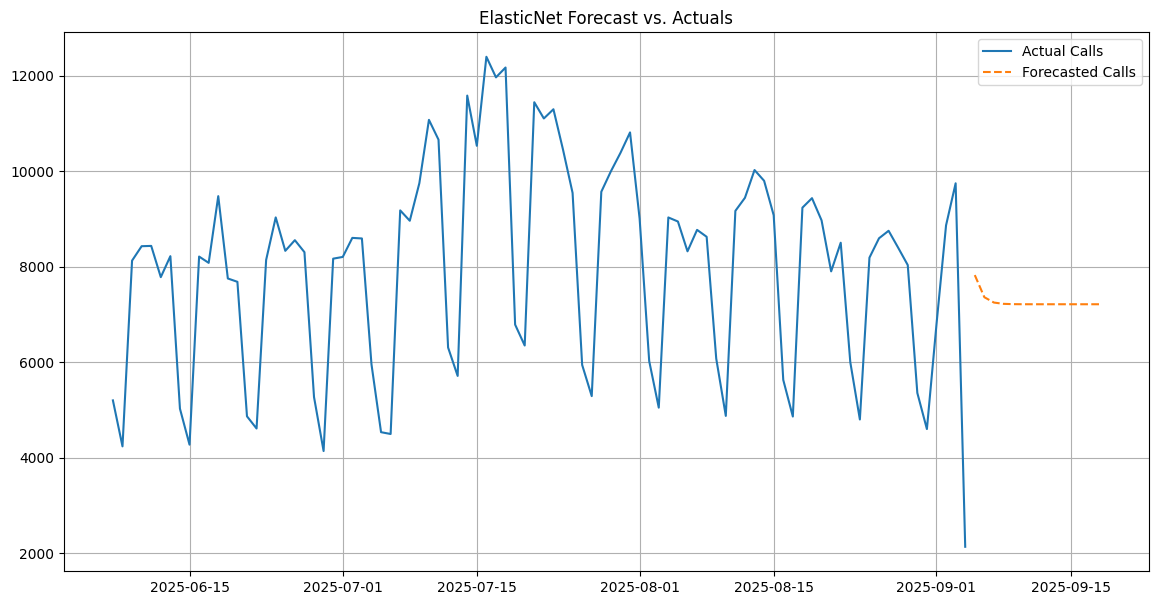


--- Running Diagnostics on Champion Model Residuals ---
ADF p-value (stationarity): 0.0000
Ljung-Box p-value (autocorrelation): 0.0000


In [6]:
# Fit the champion model on the entire dataset
print(f"\nFitting champion model '{champion_model_name}' on all data...")
champion_model_instance.fit(X, y)

# --- Forecasting Logic ---
horizon = 14
last_known_data = X.iloc[-1:].copy()
forecast_values = []

print(f"Generating a {horizon}-day forecast...")
for _ in range(horizon):
    next_pred = champion_model_instance.predict(last_known_data)[0]
    forecast_values.append(next_pred)
    last_known_data['Lag1'] = next_pred

# Create a forecast DataFrame
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D')
forecast_df = pd.DataFrame({'Forecast': forecast_values}, index=forecast_index)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df[target].tail(90), label='Actual Calls')
plt.plot(forecast_df['Forecast'], label='Forecasted Calls', linestyle='--')
plt.title(f'{champion_model_name} Forecast vs. Actuals')
plt.legend()
plt.grid(True)
plt.show()

# --- Diagnostics ---
print("\n--- Running Diagnostics on Champion Model Residuals ---")
residuals = y - champion_model_instance.predict(X)
adf_test = adfuller(residuals)
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

print(f"ADF p-value (stationarity): {adf_test[1]:.4f}")
print(f"Ljung-Box p-value (autocorrelation): {ljung_box_test['lb_pvalue'].iloc[0]:.4f}")